In [8]:
import re
import string
import os
import gc
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from datetime import datetime as dt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sqlalchemy.engine.base import Engine

from database.database import engine
from config.config import PG_USER, PG_PASS, PG_HOST, PG_PORT, PG_DATABASE

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

In [9]:
def select(query: str, conn: Engine=engine) -> pd.DataFrame:
    return pd.read_sql(query, conn)
    
users_query = "SELECT * FROM public.user_data"
posts_query = "SELECT * FROM public.post_text_df"
feeds_query = "SELECT * FROM public.feed_data WHERE action = 'view' LIMIT 5000000"

users_df = select(users_query)
posts_df = select(posts_query)
feeds_df = select(feeds_query)

users_df_path = os.path.join("data", "users_df.parquet")
posts_df_path = os.path.join("data", "posts_df.parquet")
feeds_df_path = os.path.join("data", "feeds_df.parquet")

users_df.to_parquet(users_df_path)
posts_df.to_parquet(posts_df_path)
feeds_df.to_parquet(feeds_df_path)

In [10]:
users_df = pd.read_parquet(users_df_path)
posts_df = pd.read_parquet(posts_df_path)
feeds_df = pd.read_parquet(feeds_df_path)

In [11]:
users_df.shape, posts_df.shape, feeds_df.shape

((163205, 8), (7023, 3), (5000000, 5))

In [12]:
posts_df.head(2)

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufacturing sector will continue to face serious chall...,business
1,2,Aids and climate top Davos agenda\n\nClimate change and the fight against Aids are leading the l...,business


In [13]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')


punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def preprocessing(text):
    tokens_list = word_tokenize(text.lower())
    punctuation_free = [token for token in tokens_list if token not in punctuation]
    stop_words_free = [token for token in punctuation_free if token not in stop_words]
    digits_free = [token for token in stop_words_free if not re.search(r'\d', token)]
    lemmatized = " ".join([lemmatizer.lemmatize(word) for word in digits_free]) 
    return lemmatized


vectorizer = TfidfVectorizer(preprocessor=preprocessing)
transformed_output = vectorizer.fit_transform(posts_df['text']).toarray()
tfidf_df = pd.DataFrame(
    transformed_output,
    index=posts_df.post_id,
    columns=vectorizer.get_feature_names_out())

posts_df['TotalTfIdf'] = tfidf_df.sum(axis=1).reset_index()[0]
posts_df['MaxTfIdf'] = tfidf_df.max(axis=1).reset_index()[0]
posts_df['MeanTfIdf'] = tfidf_df.mean(axis=1).reset_index()[0]


centered = tfidf_df - tfidf_df.mean(axis=0)
pca = PCA(n_components=30)
pca_decomp = pca.fit_transform(centered)


kmeans = KMeans(n_clusters=20, random_state=0).fit(pca_decomp)
posts_df['TextCluster'] = kmeans.labels_
dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster',
                 'DistanceTo16thCluster',
                 'DistanceTo17thCluster',
                 'DistanceTo18thCluster',
                 'DistanceTo19thCluster',
                 'DistanceTo20thCluster']
kmeans_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)
kmeans_df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\radio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\radio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\radio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster
0,0.526878,0.500566,0.468321,0.493319,0.453704,0.473592,0.528209,0.554430,0.134405,0.590521,0.525439,0.555615,0.581568,0.444217,0.630938,0.450184,0.448413,0.389849,0.496316,0.715257
1,0.425014,0.379107,0.344326,0.372807,0.330471,0.352208,0.444961,0.462107,0.362668,0.374262,0.414773,0.461410,0.496104,0.309526,0.551612,0.312210,0.234927,0.243784,0.385184,0.628378
2,0.465710,0.421599,0.376963,0.406115,0.384354,0.382259,0.471068,0.507068,0.272521,0.565107,0.443290,0.495304,0.516422,0.350321,0.579964,0.365337,0.384084,0.211962,0.422146,0.631807
3,0.475605,0.435212,0.387618,0.430068,0.406571,0.409499,0.504239,0.522267,0.424762,0.569861,0.464281,0.492569,0.490340,0.373402,0.592944,0.382582,0.389550,0.272473,0.430028,0.610814
4,0.331729,0.280727,0.205082,0.266597,0.233566,0.226335,0.366285,0.396834,0.351482,0.463385,0.316189,0.364757,0.407521,0.149296,0.516768,0.215709,0.230778,0.112657,0.264856,0.561480


In [14]:
posts_df = pd.concat((posts_df,kmeans_df),axis=1).drop('text', axis=1)
posts_df.head(2)

,post_id,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster
0,1,business,9.015487,0.489283,0.000208,8,0.526878,0.500566,0.468321,0.493319,0.453704,0.473592,0.528209,0.554430,0.134405,0.590521,0.525439,0.555615,0.581568,0.444217,0.630938,0.450184,0.448413,0.389849,0.496316,0.715257
1,2,business,12.082760,0.313700,0.000279,16,0.425014,0.379107,0.344326,0.372807,0.330471,0.352208,0.444961,0.462107,0.362668,0.374262,0.414773,0.461410,0.496104,0.309526,0.551612,0.312210,0.234927,0.243784,0.385184,0.628378


In [15]:
posts_df.to_sql(
   "posts_info_by_radion_nazmiev",
    con=engine,
    schema="public",
    if_exists='replace'
)

23

In [16]:
del users_query
del posts_query
del feeds_query
del nltk
del punctuation
del stop_words
del lemmatizer
del vectorizer
del transformed_output
del tfidf_df
del centered
del pca
del pca_decomp
del kmeans
del dists_columns
del kmeans_df
del PCA
del KMeans

gc.collect()

574

In [17]:
posts_processed_df_path = os.path.join("data","posts_processed_df.parquet")
posts_df.to_parquet(posts_processed_df_path)

In [18]:
posts_processed_df = pd.read_parquet(posts_processed_df_path)
posts_processed_df.head(2)

,post_id,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster
0,1,business,9.015487,0.489283,0.000208,8,0.526878,0.500566,0.468321,0.493319,0.453704,0.473592,0.528209,0.554430,0.134405,0.590521,0.525439,0.555615,0.581568,0.444217,0.630938,0.450184,0.448413,0.389849,0.496316,0.715257
1,2,business,12.082760,0.313700,0.000279,16,0.425014,0.379107,0.344326,0.372807,0.330471,0.352208,0.444961,0.462107,0.362668,0.374262,0.414773,0.461410,0.496104,0.309526,0.551612,0.312210,0.234927,0.243784,0.385184,0.628378


In [19]:
df = pd.merge(
    feeds_df,
    posts_processed_df,
    on='post_id',
    how='inner'
)
df = pd.merge(
    users_df,
    df,
    on='user_id',
    how='inner'
)

df.head(2)

,user_id,gender,age,country,city,exp_group,os,source,timestamp,post_id,action,target,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster
0,11266,1,36,Russia,Konstantinovo,0,iOS,ads,2021-11-09 15:54:59,1546,view,0,sport,8.491795,0.433501,0.000196,6,0.452281,0.379698,0.360919,0.371567,0.273207,0.345975,0.144028,0.465189,0.448752,0.541968,0.411985,0.474473,0.508634,0.316678,0.587664,0.371429,0.359121,0.334870,0.398346,0.681778
1,11266,1,36,Russia,Konstantinovo,0,iOS,ads,2021-10-02 06:34:17,3783,view,0,covid,3.123193,0.498306,0.000072,2,0.272131,0.285784,0.049584,0.271007,0.249878,0.230395,0.378668,0.413103,0.397215,0.482586,0.316153,0.305050,0.369203,0.175554,0.540778,0.293551,0.285991,0.237223,0.186249,0.594479


In [20]:
df.shape

(5000000, 37)

In [21]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month

del feeds_df
del posts_df
del users_df

df = df.set_index(['user_id', 'post_id'])

df.head(2)

gender  age country           city  exp_group   os source  \
user_id post_id                                                              
11266   1546          1   36  Russia  Konstantinovo          0  iOS    ads   
        3783          1   36  Russia  Konstantinovo          0  iOS    ads   

                          timestamp action  target  topic  TotalTfIdf  \
user_id post_id                                                         
11266   1546    2021-11-09 15:54:59   view       0  sport    8.491795   
        3783    2021-10-02 06:34:17   view       0  covid    3.123193   

                 MaxTfIdf  MeanTfIdf  TextCluster  DistanceTo1thCluster  \
user_id post_id                                                           
11266   1546     0.433501   0.000196            6              0.452281   
        3783     0.498306   0.000072            2              0.272131   

                 DistanceTo2thCluster  DistanceTo3thCluster  \
user_id post_id                                               
11266   1546                 0.379698              0.360919   
        3783                 0.285784              0.049584   

                 DistanceTo4thCluster  DistanceTo5thCluster  \
user_id post_id                                               
11266   1546                 0.371567              0.273207   
        3783                 0.271007              0.249878   

                 DistanceTo6thCluster  DistanceTo7thCluster  \
user_id post_id                                               
11266   1546                 0.345975              0.144028   
        3783                 0.230395              0.378668   

                 DistanceTo8thCluster  DistanceTo9thCluster  \
user_id post_id                                               
11266   1546                 0.465189              0.448752   
        3783                 0.413103              0.397215   

                 DistanceTo10thCluster  DistanceTo11thCluster  \
user_id post_id                                                 
11266   1546                  0.541968               0.411985   
        3783                  0.482586               0.316153   

                 DistanceTo12thCluster  DistanceTo13thCluster  \
user_id post_id                                                 
11266   1546                  0.474473               0.508634   
        3783                  0.305050               0.369203   

                 DistanceTo14thCluster  DistanceTo15thCluster  \
user_id post_id                                                 
11266   1546                  0.316678               0.587664   
        3783                  0.175554               0.540778   

                 DistanceTo16thCluster  DistanceTo17thCluster  \
user_id post_id                                                 
11266   1546                  0.371429               0.359121   
        3783                  0.293551               0.285991   

                 DistanceTo18thCluster  DistanceTo19thCluster  \
user_id post_id                                                 
11266   1546                  0.334870               0.398346   
        3783                  0.237223               0.186249   

                 DistanceTo20thCluster  hour  month  
user_id post_id                                      
11266   1546                  0.681778    15     11  
        3783                  0.594479     6     10

In [22]:
max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:51:06'), Timestamp('2021-10-01 06:05:25'))

In [23]:
df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop(['timestamp','action'], axis=1)
df_test = df_test.drop(['timestamp','action'], axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

del df
del df_train
del df_test

y_train.shape, y_test.shape

((4169031,), (830969,))

In [17]:
object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]


cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)


pipe_dt = Pipeline([("column_transformer",
                     col_transform),

                    ("decision_tree",
                     DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)

D:\DS\recommendation_system_project\rec_sys\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
D:\DS\recommendation_system_project\rec_sys\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
D:\DS\recommendation_system_project\rec_sys\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
D:\DS\recommendation_system_project\rec_sys\lib\site-packages\category_encoders\one_hot.py:145: FutureWarn

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [0, 33, 5, 6]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [7, 11, 2, 3, 4, 32])])),
                ('decision_tree', DecisionTreeClassifier())])

In [18]:
print(f"Качество на трейне: {roc_auc_score(y_train, pipe_dt.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.9150714867964151
Качество на тесте: 0.535832044808839


In [19]:
catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2,
                              random_seed=100)

catboost.fit(X_train, y_train, object_cols, logging_level='Verbose')

D:\DS\recommendation_system_project\rec_sys\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 0.3581152	total: 854ms	remaining: 1m 24s
1:	learn: 0.3511486	total: 1.47s	remaining: 1m 12s
2:	learn: 0.3500000	total: 2s	remaining: 1m 4s
3:	learn: 0.3491919	total: 2.48s	remaining: 59.6s
4:	learn: 0.3490139	total: 2.94s	remaining: 55.9s
5:	learn: 0.3487392	total: 3.38s	remaining: 53s
6:	learn: 0.3486403	total: 3.85s	remaining: 51.1s
7:	learn: 0.3486148	total: 4.26s	remaining: 49s
8:	learn: 0.3484385	total: 4.7s	remaining: 47.5s
9:	learn: 0.3483908	total: 5.13s	remaining: 46.2s
10:	learn: 0.3483706	total: 5.54s	remaining: 44.8s
11:	learn: 0.3483357	total: 5.96s	remaining: 43.7s
12:	learn: 0.3477555	total: 6.44s	remaining: 43.1s
13:	learn: 0.3474070	total: 6.89s	remaining: 42.4s
14:	learn: 0.3473155	total: 7.36s	remaining: 41.7s
15:	learn: 0.3472671	total: 7.75s	remaining: 40.7s
16:	learn: 0.3471099	total: 8.2s	remaining: 40s
17:	learn: 0.3470854	total: 8.6s	remaining: 39.2s
18:	learn: 0.3466709	total: 9.03s	remaining: 38.5s
19:	learn: 0.3464807	total: 9.46s	remaining: 37.9s


In [20]:
print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6663082318687871


D:\DS\recommendation_system_project\rec_sys\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Качество на тесте: 0.6468967472807345


In [21]:
catboost.save_model(
    'catboost_model',
    format="cbm"
)

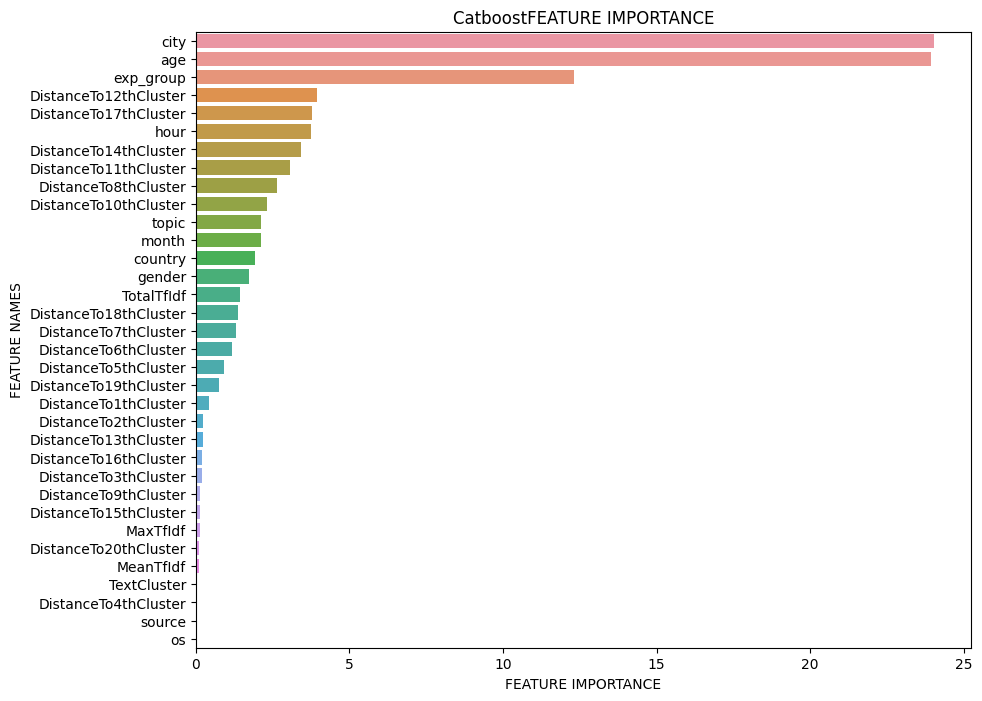

In [22]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')

In [6]:
test = pd.read_parquet('df.parquet')
test.shape

(600000, 2)